In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/swake17/SeniorHousing_TimeSeries/main/SeniorHousing.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21902 entries, 0 to 21901
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Quarter              21902 non-null  object 
 1   State                21902 non-null  object 
 2   Property Type        21902 non-null  object 
 3   Market               21902 non-null  object 
 4   Properties           21902 non-null  float64
 5   Units                21902 non-null  float64
 6   Occupancy            21902 non-null  float64
 7   Occupied             21902 non-null  float64
 8   Construction         21902 non-null  float64
 9   EFFR                 21902 non-null  float64
 10  ElderlyPop_National  5083 non-null   float64
 11  ElderlyPop_State     5083 non-null   float64
 12  City                 21902 non-null  object 
 13  County               21902 non-null  object 
 14  ElderlyPop_County    4809 non-null   float64
dtypes: float64(9), object(6)
memory usag

###Notes on a few variable names

`Property Type` reflect a continuum of healthcare services provided, ascending order:

*  IL: Independent Living
*  AL: Assisted Living
*  NC: Nursing Care



`Market` refers to market sizes devised by NICMAP - primary, secondary, additional

`EFFR` refers to effective federal funds rate, also known as the federal interest rate



#Exploratory Data Analysis

###Aggregating all 3 property types

In [3]:
#first, aggregate over property types
#this step is only necessary in terms of providing the aggregated population estimates from states/counties
#included in NICMAP, rather than using overall national population from Census dataset
df_all_properties = df.groupby(['Quarter', 'State', 'County', 'City']).agg({'Units' : 'sum',
                                                                            'Occupied': 'sum',
                                                                            'Construction': 'sum',
                                                                            'EFFR' : 'mean',
                                                                            'ElderlyPop_County' : 'mean' #mean estimates because population is repeated for all 4 property types
                                                                            }).reset_index()


#Now aggregate over Quarters
df_agg = df_all_properties.groupby('Quarter').agg({'Units' : 'sum',
                                                  'Occupied': 'sum',
                                                  'Construction': 'sum',
                                                  'EFFR' : 'mean',
                                                  'ElderlyPop_County' : 'sum' #Now only one population estimate per county - so sum them per quarter
                                                  }).reset_index()


In [4]:
#Do any counties include more than one city?
print('number of counties which include multiple cities: ')
print(df_all_properties.duplicated(subset=['Quarter', 'State', 'County']).sum())

number of counties which include multiple cities: 
0


Worth noting that no counties in the dataset include more than 1 city, so analysis based on counties will be identical to one based on cities

###Overall Time Series Trend of Occupancy Rate

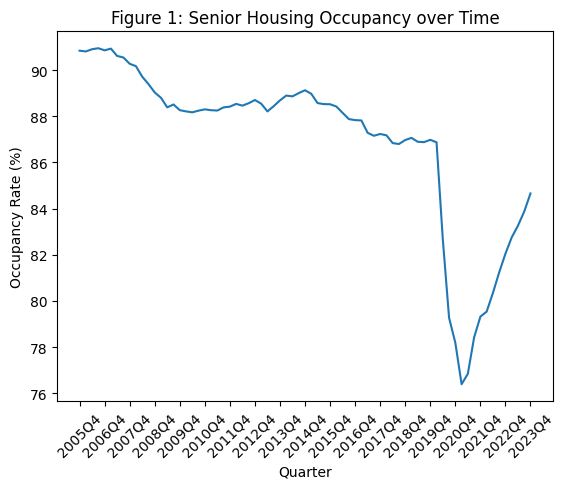

In [5]:
df_agg = df_agg.assign(Occupancy = 100*df_agg.Occupied/df_agg.Units)

#space out Quarters by 4 on x axis
xlabels = df_agg.Quarter[np.arange(len(df_agg.Quarter), step=4)]

plt.plot(df_agg.Quarter, df_agg.Occupancy)
plt.xticks(rotation=45)
plt.xticks(xlabels)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Occupancy Rate (%)')
plt.xlabel('Quarter')
plt.title('Figure 1: Senior Housing Occupancy over Time')
plt.show()

###What are the individual trends in supply and demand of which occupancy is composed?

In [6]:
#Does the dataset contain the same markets over time?

total_markets = df.groupby('Quarter').County.nunique()
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(total_markets)

Quarter
2005Q4     30
2006Q1     30
2006Q2     30
2006Q3     31
2006Q4     31
2007Q1     31
2007Q2     31
2007Q3     31
2007Q4     31
2008Q1     94
2008Q2     94
2008Q3     94
2008Q4     94
2009Q1     94
2009Q2     94
2009Q3     94
2009Q4     94
2010Q1     94
2010Q2     94
2010Q3     94
2010Q4     94
2011Q1     94
2011Q2     94
2011Q3     94
2011Q4     94
2012Q1     94
2012Q2     94
2012Q3     94
2012Q4     94
2013Q1     94
2013Q2     94
2013Q3     94
2013Q4     94
2014Q1     94
2014Q2     94
2014Q3     94
2014Q4     94
2015Q1     99
2015Q2    124
2015Q3    126
2015Q4    126
2016Q1    125
2016Q2    125
2016Q3    130
2016Q4    130
2017Q1    130
2017Q2    130
2017Q3    130
2017Q4    130
2018Q1    132
2018Q2    132
2018Q3    132
2018Q4    132
2019Q1    132
2019Q2    132
2019Q3    132
2019Q4    132
2020Q1    132
2020Q2    132
2020Q3    133
2020Q4    133
2021Q1    132
2021Q2    132
2021Q3    132
2021Q4    132
2022Q1    131
2022Q2    133
2022Q3    133
2022Q4    132
2023Q1    132
2023Q2    13

Dataset expands the number of market it includes in 2008Q1, and again in 2015Q1. Observe genuine supply and demand growth by focusing only on those properties included beginning in 2008Q1

In [7]:
#get list of unique markets/counties from 2008Q1
q1_2008 = df[df.Quarter == '2008Q1']
supply_counties = q1_2008.County.unique()

#create dataset beginning in 2008Q1
#include only the unique counties above (e.g. excluding the new additions beginning 2015Q1)
supply_df = df[df.Quarter >= '2008Q1']
supply_df = supply_df[(supply_df.County.isin(supply_counties))]

#Aggregate overall occupancy trend on this new dataset
supply_df_agg = supply_df.groupby('Quarter').agg({'Units' : 'sum',
                                                  'Occupied': 'sum',
                                                  'Construction': 'sum',
                                                  'EFFR' : 'mean',
                                                  'ElderlyPop_County' : 'sum'}).reset_index()

supply_df_agg['Occupancy'] = 100*supply_df.Occupied/supply_df.Units

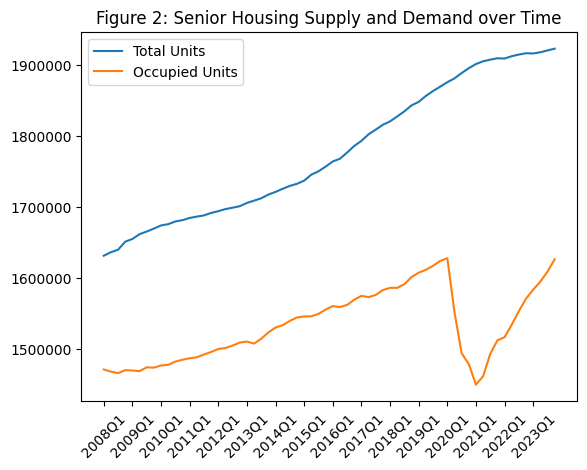

In [8]:
xlabels = supply_df_agg.Quarter[np.arange(len(supply_df_agg.Quarter), step=4)]

fig, ax = plt.subplots()
plt.plot(supply_df_agg.Quarter, supply_df_agg.Units, label = 'Total Units')
plt.plot(supply_df_agg.Quarter, supply_df_agg.Occupied, label = 'Occupied Units')
plt.xticks(xlabels)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.title('Figure 2: Senior Housing Supply and Demand over Time')
plt.show()

Disentangling supply and demand, you can see that the slow decline in occupancy rates seen in Figure 1,  beginning around 2014, is due to an accelarting supply of housing which outpaced the constant rate of growth in demand.

The precipitous drop in demand from the COVID-19 pandemic beginning in 2020 caused occupancy to drop even further, exacerbating the existing trend.

##Closer look: comparing property types and market sizes

###Property Type

In [9]:
property_data = df.groupby(['Quarter', 'Property Type'])[['Units', 'Occupied']].sum().reset_index()
property_data['Occupancy'] = 100*property_data.Occupied/property_data.Units

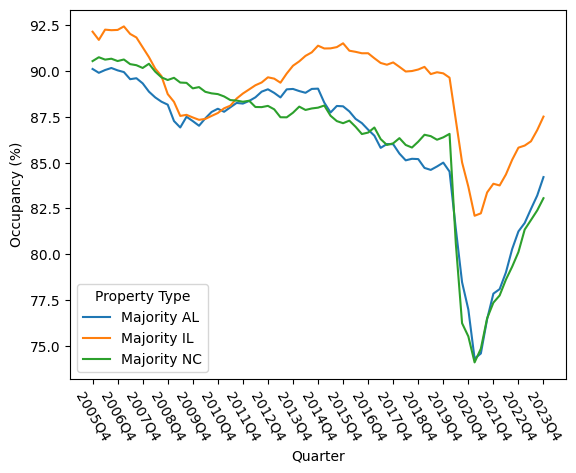

In [10]:
xlabels = property_data.Quarter[np.arange(len(property_data.Quarter), step=12)]


sns.lineplot(data = property_data, x='Quarter', y='Occupancy', hue='Property Type', palette = "tab10")
plt.xticks(xlabels)
plt.xticks(rotation=-60)
plt.ylabel('Occupancy (%)')
plt.show()

Can see that Independent Living Facilities experienced the smalles drop in occupancy during the pandemic. This makes sense as the drop in decline was primarily due to mortality due to the virus, which affects those with lower health to begin with.

###Market Size

In [11]:
market_sizes = df[['State', 'County', 'Market']].drop_duplicates()
data = df.merge(market_sizes, on = ['State', 'County'], how='left')

In [12]:
markets_data = df.groupby(['Quarter', 'Market'])[['Units', 'Occupied']].sum().reset_index()
markets_data['Occupancy'] = 100*markets_data.Occupied/markets_data.Units

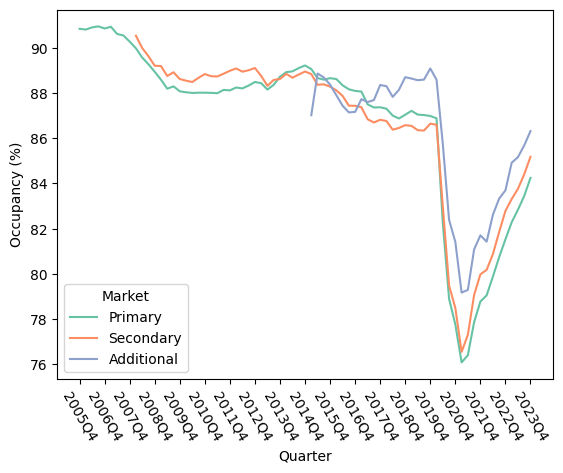

In [13]:
xlabels= [str(i) + 'Q4' for i in range(2005,2024)]


sns.lineplot(data = markets_data, x='Quarter', y='Occupancy', hue='Market', palette='Set2')

plt.xticks(xlabels)
plt.xticks(rotation=-60)
plt.ylabel('Occupancy (%)')
plt.show()


# Time Series Analysis

In [14]:
#first, assign `State_County` feature referring to the state and county, to account for county names which appear in multiple states
df['State_County'] = df.State + '_' + df.County

###Elderly Population

census data is measured only once per year - use linear interpolation to fill in values for remaing quarters

In [15]:
#define a function to linearly interpolate within non null values, and then extrapolate outside of nonnull value range (rather than filling these values by duplicating value on the end of range)
def extrap(df):
  pops = df
  pops['pop_inter'] = pops.interpolate(limit_area = 'inside')
  if pops.index[0] != pops.first_valid_index():
    first = pops[pops.index < pops.first_valid_index()].shape[0]
    low_step = pops['pop_inter'][first+1] - pops['pop_inter'][first]
    for i in range(first)[::-1]:
      pops['pop_inter'][i] = pops['pop_inter'][i+1] - low_step

  if pops.index[-1] != pops.last_valid_index():
    last = pops.shape[0] - pops[pops.index > pops.last_valid_index()].shape[0]
    high_step = pops['pop_inter'][last-1] - pops['pop_inter'][last-2]
    for i in range(last, (pops.shape[0])):
      pops['pop_inter'][i] = pops['pop_inter'][i-1] + high_step
  return(pops)


interp_extrap_pops = pd.DataFrame(columns = ['Quarter', 'pop_inter', 'State_County'])

for loc in df.State_County.unique():
  county = df.loc[(df.State_County == loc).values, :]
  pops = pd.DataFrame(county.groupby('Quarter')['ElderlyPop_County'].mean())
  pops_ext = extrap(pops)
  pops_ext['State_County'] = loc
  pops_ext = pops_ext.reset_index().drop(['ElderlyPop_County'], axis=1)
  interp_extrap_pops = pd.concat([interp_extrap_pops, pops_ext], axis=0)

df_pops = df.merge(interp_extrap_pops)

In [16]:
df_pops

,Quarter,State,Property Type,Market,Properties,Units,Occupancy,Occupied,Construction,EFFR,ElderlyPop_National,ElderlyPop_State,City,County,ElderlyPop_County,State_County,pop_inter
0,2005Q4,GA,Majority IL,Primary,24.0,4241.0,88.6,3757.0,699.0,3.98,NaN,NaN,Atlanta,FULTON,NaN,GA_FULTON,20020.5
1,2005Q4,GA,Majority AL,Primary,124.0,7524.0,92.3,6945.0,91.0,3.98,NaN,NaN,Atlanta,FULTON,NaN,GA_FULTON,20020.5
2,2005Q4,GA,Majority NC,Primary,99.0,13896.0,93.6,13000.0,0.0,3.98,NaN,NaN,Atlanta,FULTON,NaN,GA_FULTON,20020.5
3,2005Q4,MD,Majority IL,Primary,18.0,8249.0,97.0,8000.0,305.0,3.98,NaN,NaN,Baltimore,BALTIMORE,NaN,MD_BALTIMORE,37150.0
4,2005Q4,MD,Majority AL,Primary,51.0,3621.0,89.6,3243.0,90.0,3.98,NaN,NaN,Baltimore,BALTIMORE,NaN,MD_BALTIMORE,37150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21897,2023Q4,NC,Majority AL,Additional,33.0,2210.0,81.9,1811.0,0.0,5.33,NaN,NaN,Winston-Salem,FORSYTH,NaN,NC_FORSYTH,15024.0
21898,2023Q4,NC,Majority NC,Additional,20.0,2310.0,83.1,1919.0,0.0,5.33,NaN,NaN,Winston-Salem,FORSYTH,NaN,NC_FORSYTH,15024.0
21899,2023Q4,PA,Majority IL,Additional,6.0,1531.0,88.7,1358.0,0.0,5.33,NaN,NaN,York,YORK,NaN,PA_YORK,20927.0
21900,2023Q4,PA,Majority AL,Additional,12.0,1357.0,91.6,1243.0,0.0,5.33,NaN,NaN,York,YORK,NaN,PA_YORK,20927.0


##COVID-19 Pandemic

* Began roughly 2020 Q2
* Ended *(roughly)* 2021 Q4

Create categorical variable `Covid_Timeline` for each of these seven quarters, indicating their situation within the pandemic timeline

* 2020 Q2
* 2020 Q3
* 2020 Q4
* 2021 Q1
* 2021 Q2
* 2021 Q3
* 2021 Q4

In [17]:
pandemic_quarters = ['2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3', '2021Q4']

df_pops['Covid_Timeline'] = 'No'
for q in pandemic_quarters:
  df_pops.loc[(df_pops.Quarter == q).values, 'Covid_Timeline'] = q

In [18]:
df_pops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21902 entries, 0 to 21901
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Quarter              21902 non-null  object 
 1   State                21902 non-null  object 
 2   Property Type        21902 non-null  object 
 3   Market               21902 non-null  object 
 4   Properties           21902 non-null  float64
 5   Units                21902 non-null  float64
 6   Occupancy            21902 non-null  float64
 7   Occupied             21902 non-null  float64
 8   Construction         21902 non-null  float64
 9   EFFR                 21902 non-null  float64
 10  ElderlyPop_National  5083 non-null   float64
 11  ElderlyPop_State     5083 non-null   float64
 12  City                 21902 non-null  object 
 13  County               21902 non-null  object 
 14  ElderlyPop_County    4809 non-null   float64
 15  State_County         21902 non-null 

#Univariate analysis - target variable

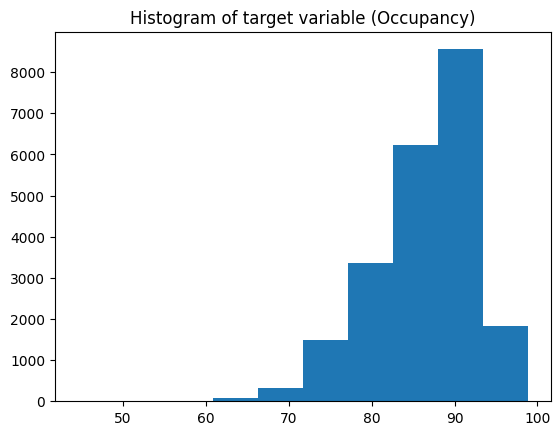

Jarque_bera test stat: 3618.497904606381
p value: 0.0
Normal test stat: 2534.8924819773583
p value: 0.0


In [19]:
targets= df_pops.Occupancy
plt.hist(targets)
plt.title('Histogram of target variable (Occupancy)')
plt.show()

from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb = jarque_bera(targets)
nm = normaltest(targets)

print('Jarque_bera test stat: {0}\np value: {1}'.format(jb[0], jb[1]))
print('Normal test stat: {0}\np value: {1}'.format(nm[0], nm[1]))


###Box-Cox Transform
##### Occupancies are skewed right - apply box cox transform to obtain normal distribution

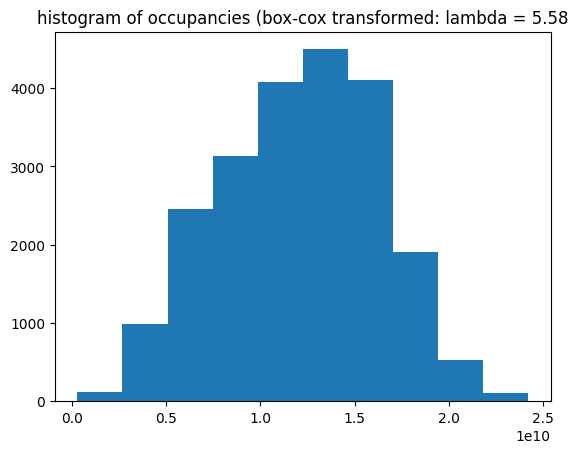

Jarque_bera test stat: [1.31160727e+10 1.64788853e+10 1.78161676e+10 ... 1.31988732e+10
 1.57936695e+10 8.80995787e+09]
p value: 1.00000010251974


In [20]:
from scipy.stats import boxcox

targets_boxcox,lmda = boxcox(targets)

plt.hist(targets_boxcox)
plt.title('histogram of occupancies (box-cox transformed: lambda = ' + str("%.2f"
 % lmda))
plt.show()

jb_boxcox = boxcox(targets_boxcox)
print('Jarque_bera test stat: {0}\np value: {1}'.format(jb_boxcox[0], jb_boxcox[1]))

###Outliers

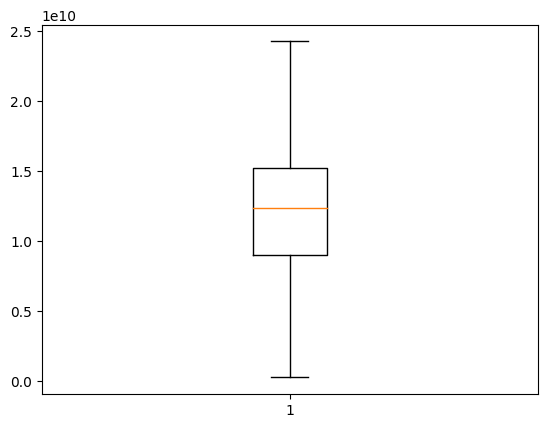

In [21]:
plt.boxplot(targets_boxcox);

####Winsorize to eliminate outliers

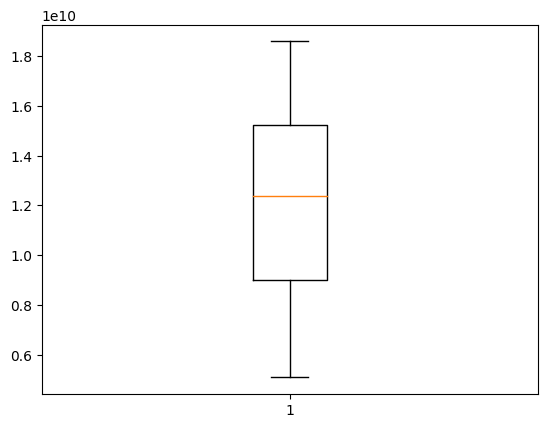

In [22]:
from scipy.stats.mstats import winsorize
targets_boxcox_winsorized = winsorize(targets_boxcox, (0.05, 0.05))
plt.boxplot(targets_boxcox_winsorized);

In [23]:
#Assign transformed target variable to dataframe as Y
df_pops['Y'] = targets_boxcox_winsorized

###Time Lag

Time series analysis will be conducted using supervised learning, with occupancy rates estimated from the following features:

 * Time lagged occupancy rates
 * Elderly population (80+ years old) : current and time lagged
 * EFFR: current and time lagged
 * Co-occurence with the COVID-19 pandemic


Each row in dataset refers to one specific county. So for a given occupancy rate, the time lag must be in reference to that county only

In [24]:
#Create function that takes arguments for a dataframe (containing multiple counties) and a specific county
#creates a time series for that county only. Which features to create time lags for
#as well as number of time lags are provided as arguments

def create_county_timelag(dataframe, State_County, lag_steps, features):
  cty_prop = pd.DataFrame()
  for prop in dataframe['Property Type'].unique():
    county_df = dataframe[(dataframe.State_County == State_County).values & (dataframe['Property Type'] == prop).values]
    for feature in features:
      for i in range(1, lag_steps+1):
        county_df[feature + '_t-' + str(i)] = county_df[feature].shift(i)
  cty_prop = pd.concat([cty_prop, county_df], axis=0)
  return(cty_prop)

#Iteratively apply over dataframe
features_list = ['Units', 'Y', 'pop_inter','EFFR']
statecounties = df_pops.State_County.unique()


import warnings
warnings.filterwarnings('ignore')
df_lag = pd.DataFrame()
for cty in statecounties:
  county_df = create_county_timelag(df_pops, cty, 5, features_list)
  df_lag = pd.concat([df_lag, county_df], axis=0)


warnings.filterwarnings('default')
df_lag = df_lag.reset_index().drop('index', axis=1)

In [25]:
df_lag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7694 entries, 0 to 7693
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Quarter              7694 non-null   object 
 1   State                7694 non-null   object 
 2   Property Type        7694 non-null   object 
 3   Market               7694 non-null   object 
 4   Properties           7694 non-null   float64
 5   Units                7694 non-null   float64
 6   Occupancy            7694 non-null   float64
 7   Occupied             7694 non-null   float64
 8   Construction         7694 non-null   float64
 9   EFFR                 7694 non-null   float64
 10  ElderlyPop_National  1789 non-null   float64
 11  ElderlyPop_State     1789 non-null   float64
 12  City                 7694 non-null   object 
 13  County               7694 non-null   object 
 14  ElderlyPop_County    1686 non-null   float64
 15  State_County         7694 non-null   o

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
df_lag.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Quarter', 'State', 'Property Type', 'Market', 'Properties', 'Units',
       'Occupancy', 'Occupied', 'Construction', 'EFFR', 'ElderlyPop_National',
       'ElderlyPop_State', 'City', 'County', 'ElderlyPop_County',
       'State_County', 'pop_inter', 'Covid_Timeline', 'Y', 'Units_t-1',
       'Units_t-2', 'Units_t-3', 'Units_t-4', 'Units_t-5', 'Y_t-1', 'Y_t-2',
       'Y_t-3', 'Y_t-4', 'Y_t-5', 'pop_inter_t-1', 'pop_inter_t-2',
       'pop_inter_t-3', 'pop_inter_t-4', 'pop_inter_t-5', 'EFFR_t-1',
       'EFFR_t-2', 'EFFR_t-3', 'EFFR_t-4', 'EFFR_t-5'],
      dtype='object')

#Supervised Learning


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = df_lag.drop(['Quarter', 'Construction', 'State', 'ElderlyPop_National',
       'ElderlyPop_State', 'City', 'County', 'ElderlyPop_County',
       'State_County', 'Occupancy'], axis=1)

df = df.dropna()

#scale numeric features
scaler = StandardScaler()
numeric_columns = df.select_dtypes(include=['float64'])
numeric_columns_scaled = pd.DataFrame(scaler.fit_transform(numeric_columns), columns = numeric_columns.columns)

#one hot encode categorical features
categorical_columns = pd.get_dummies(df.select_dtypes(include=['object']), drop_first=True, dtype=int).reset_index().drop('index', axis=1)

data = pd.concat([numeric_columns_scaled, categorical_columns], axis=1)




In [35]:
data

,Properties,Units,Occupied,EFFR,pop_inter,Y,Units_t-1,Units_t-2,Units_t-3,Units_t-4,...,EFFR_t-5,Market_Primary,Market_Secondary,Covid_Timeline_2020Q3,Covid_Timeline_2020Q4,Covid_Timeline_2021Q1,Covid_Timeline_2021Q2,Covid_Timeline_2021Q3,Covid_Timeline_2021Q4,Covid_Timeline_No
0,0.479856,0.422269,0.495770,2.734266,-0.378996,1.512037,0.421737,0.421045,0.420507,0.419849,...,2.675225,1,0,0,0,0,0,0,0,1
1,0.479856,0.422038,0.494302,2.734266,-0.376137,1.486717,0.421583,0.421045,0.420353,0.419849,...,3.077188,1,0,0,0,0,0,0,0,1
2,0.479856,0.422038,0.499568,2.615657,-0.373296,1.588749,0.421352,0.420891,0.420353,0.419696,...,3.470599,1,0,0,0,0,0,0,0,1
3,0.479856,0.422038,0.494906,2.240064,-0.370455,1.486717,0.421352,0.420661,0.420200,0.419696,...,3.761381,1,0,0,0,0,0,0,0,1
4,0.479856,0.424576,0.510187,1.370268,-0.367615,1.772180,0.421352,0.420661,0.419969,0.419542,...,3.752829,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6621,-0.734491,-0.603379,-0.587748,1.679968,-0.711189,-1.485174,-0.603436,-0.603471,-0.603480,-0.603499,...,-0.651664,0,0,0,0,0,0,0,0,1
6622,-0.734491,-0.607686,-0.588007,2.246653,-0.711130,-1.245648,-0.603436,-0.603471,-0.603480,-0.603499,...,-0.660216,0,0,0,0,0,0,0,0,1
6623,-0.734491,-0.607686,-0.588784,2.562942,-0.711071,-1.428507,-0.607740,-0.603471,-0.603480,-0.603499,...,-0.626007,0,0,0,0,0,0,0,0,1
6624,-0.734491,-0.607686,-0.587402,2.740855,-0.711012,-1.089271,-0.607740,-0.607773,-0.603480,-0.603499,...,-0.070100,0,0,0,0,0,0,0,0,1


In [99]:
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn import neighbors

Y = data['Y']
X = data.drop(['Y', 'EFFR'], axis=1)#drop effr for current time point, but leave time lags

cv = RepeatedKFold(n_splits=10, n_repeats=3)

#simple regression
lr = LinearRegression()
lr_score = cross_val_score(lr, X, Y, cv = cv, scoring = 'neg_mean_squared_error')

#SGD gridsearch
sgd = SGDRegressor()
sgd_param_grid = {
    'max_iter': [500, 1000, 2000, 5000],
    'penalty' : ['l1', 'l2', None],
    'alpha' : 10.0 ** -np.arange(1, 5),
}

sgd_search = GridSearchCV(sgd, param_grid = sgd_param_grid, scoring = 'neg_mean_squared_error', cv = cv)
sgd_result = sgd_search.fit(X,Y)
#KNN
knn_param_grid = {
    'n_neighbors' : [1,2,3,4,5,10, 15, 20],
    'weights' : ['distance', 'uniform'],
}

knn = neighbors.KNeighborsRegressor()

knn_search = GridSearchCV(knn, param_grid=knn_param_grid,scoring = 'neg_mean_squared_error', cv=cv)
knn_result = knn_search.fit(X,Y)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [100]:
print('Mean squared error of each model:')
print('Linear Regression score: {}'.format(lr_score.mean()))
print('SGD gridsearch score: {}'.format(sgd_result.best_score_))
print('KNN gridsearch score: {}'.format(knn_result.best_score_))

Mean squared error of each model:
Linear Regression score: -0.05435681074359105
SGD gridsearch score: -0.062103996397854765
KNN gridsearch score: -0.07271515143084377


###Visualizing predicted vs true values

#####Linear Regression:

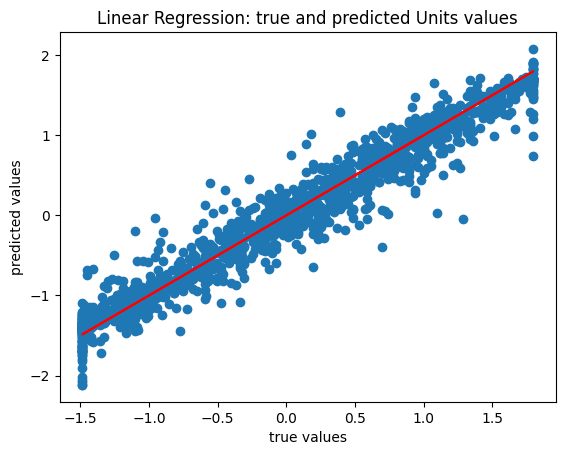

Mean absolute error of the prediction is: 0.16698871641594756
Mean squared error of the prediction is: 0.05330297289772496
Root mean squared error of the prediction is: 0.23087436604726164


In [102]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

#Best model: Linear Regression

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Linear Regression: true and predicted Units values")
plt.show()


print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))


#####KNN:

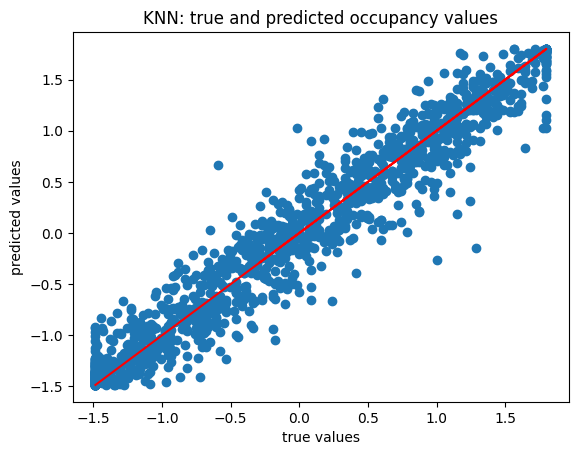

{'n_neighbors': 5, 'weights': 'distance'}
Mean absolute error of the prediction is: 0.18256707002752817
Mean squared error of the prediction is: 0.06311276552413617
Root mean squared error of the prediction is: 0.2512225418312142


In [103]:
#2nd Best: KNN
#visualize with scatter plot

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

#get parameters from gridsearch
params = knn_result.best_params_



knn = neighbors.KNeighborsRegressor(**params)
knn.fit(X_train, y_train)

y_preds = knn.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("KNN: true and predicted occupancy values")
plt.show()

print(params)
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))


###ANN

In [37]:
Y = data['Y']
X = data.drop(['Y', 'EFFR'], axis=1)#drop effr for current time point, but leave time lags


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)


model = Sequential()
model.add(Dense(33, input_shape=(33,), kernel_initializer='normal', activation='relu'))
model.add(Dense(11, activation = 'relu'))

model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=10, verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.4573
Epoch 2/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0715
Epoch 3/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0643
Epoch 4/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0607
Epoch 5/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0583
Epoch 6/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0542
Epoch 7/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0577
Epoch 8/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0532
Epoch 9/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0491
Epoch 10/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0551
Epoch 11/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0539
Epoch 12/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0557
Epoch 13/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0558
Epoch 14/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0579
Epoch 15/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0547

####Visualizing predictions vs true values

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


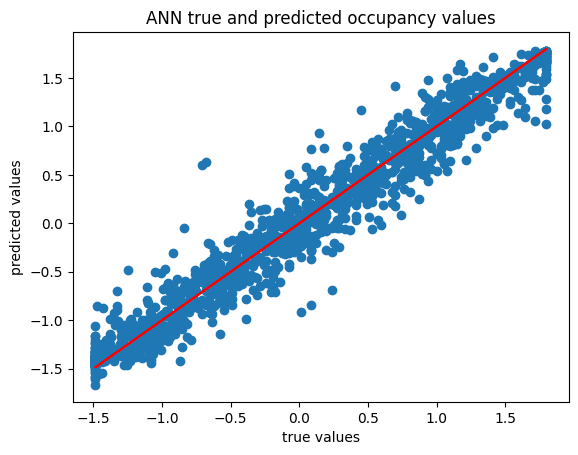

Mean absolute error of the prediction is: 0.16025059422141358
Mean squared error of the prediction is: 0.04726172262180927
Root mean squared error of the prediction is: 0.21739761411250416


In [45]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

y_preds = model.predict(X_test)
y_preds = y_preds.flatten()

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("ANN true and predicted occupancy values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))